# Transformer based Neural Network for RUL Prediction

## Introduction

This notebook focuses on designing and implementing neural network models for predicting the Remaining Useful Life (RUL) of engines using the NASA CMAPSS dataset and a transformer based model. The dataset provides multivariate time-series data capturing engine operational and sensor measurements. By analyzing these sequences, we aim to estimate the RUL, which is critical for predictive maintenance and avoiding unexpected failures.

In this notebook we are going to NOT use the **engineered** features.

### Objectives
1. **Develop a Baseline Model:** (Done)
   - Implement a baseline neural network using **RNN** layers to leverage the sequential nature of the data.
   - Evaluate the baseline model's performance as a benchmark.

2. **Experiment with more complex models like GRU and Transformer-Based Models:**
   - Implement a more advanced architecture based on transformers for sequence modeling and feature extraction.
   - Compare its performance with the LSTM-based baseline model.

### Plan
1. **Prepare the Data:**
   - Use the preprocessed and scaled dataset created in previous notebooks.
   - Ensure the dataset supports both original features and optional engineered features for flexibility in experimentation.

2. **Baseline Model (LSTM):**
   - Use LSTM layers to capture temporal dependencies in the sequence data.
   - Evaluate the model's performance using Mean Squared Error (MSE) as the loss metric.

3. **Transformer-Based Model:**
   - Design a transformer architecture for sequence-to-sequence modeling.
   - Focus on capturing long-range dependencies and complex interactions among features.

4. **Model Comparison and Evaluation:**
   - Compare the models on key metrics such as Mean Absolute Error (MAE) and MSE.
   - Analyze the advantages and trade-offs of each approach.

### Why Use LSTMs and Transformers?
- **LSTMs:** 
  - Effective at capturing temporal dependencies and patterns in sequential data.
  - Provide a strong benchmark for sequence modeling tasks.
- **Transformers:**
  - Offer enhanced capability to model long-range dependencies compared to LSTMs.
  - Utilize attention mechanisms to focus on the most relevant parts of the sequence.

### Expected Outcome
By the end of this notebook, we aim to:
- Establish a strong baseline model for RUL prediction.
- Explore the potential of transformer-based models for handling sequence data.
- Gain insights into the strengths and limitations of these architectures for predictive maintenance tasks.

Let's begin by loading the prepared dataset and setting up the baseline model.


# Preparing our existing CMAPSSDataset for a transformer based network
Our sequence based CMAPSSDataset is already in good shape to serve as a data pipeline for the transformer net architecture. But we need to add one thing:

1. Creating an attention mask to ignore padded timesteps

**Another** task is:

1. Clarify the question how you pool the final sequence embedding (mean pooling, [CLS] token, etc.)


## Pooling the Final Sequence Embedding in Transformer Models

Pooling the **final sequence embeddings** is a critical step in Transformer-based models for time-series tasks like RUL prediction. Let’s break it down and explore the options:

---

### 1. **Why Do You Need Pooling?**

The Transformer outputs embeddings for **each timestep** (sequence position). For example:
- Input: Shape $(\text{batch size}, \text{seq len}, \text{feature dim})$
- Transformer Output: Shape $(\text{batch size}, \text{seq len}, \text{d\_model})$

Each row in this output corresponds to the representation of a specific timestep, enriched by attention over the entire sequence. However:
- For **RUL prediction**, you need a **single output vector** per sequence because RUL is a scalar (one value per sequence).
- To get this single vector, you must **pool** the sequence embeddings into one representation.

---

### 2. **Common Pooling Strategies**

#### 2.1. **Mean Pooling (Global Average Pooling)**

- Take the average of all timestep embeddings across the sequence:
  $$
  \text{pooled\_vector} = \frac{1}{\text{seq len}} \sum_{t=1}^{\text{seq len}} \text{embeddings}[t]
  $$
- This results in a single vector of shape $(\text{batch size}, \text{d\_model})$.

**Advantages**:
- Simple and computationally efficient.
- Works well when every timestep contributes equally to the sequence’s meaning.

**Disadvantages**:
- Assumes all timesteps are equally important, which may not hold if some timesteps contain more critical information (e.g., degradation trends at later cycles).

---

#### 2.2. **Max Pooling**

- Take the maximum value across timesteps for each embedding dimension:
  $$
  \text{pooled\_vector}[i] = \max_{t=1}^{\text{seq len}} \text{embeddings}[t][i]
  $$
- Shape: $(\text{batch size}, \text{d\_model})$.

**Advantages**:
- Focuses on the most “prominent” features across the sequence, which may highlight key degradation signals.

**Disadvantages**:
- Discards subtler variations across timesteps, which might be useful for RUL prediction.

---

#### 2.3. **Attention-Based Pooling**

Instead of fixed pooling (mean or max), you can use an **attention mechanism** to compute a weighted sum of embeddings:
- Learn a weight for each timestep based on its importance.
- Formula:
  $$
  \text{pooled\_vector} = \sum_{t=1}^{\text{seq len}} \alpha_t \cdot \text{embeddings}[t]
  $$
  where $\alpha_t$ are attention weights:
  $$
  \alpha_t = \text{softmax}(W \cdot \text{embeddings}[t])
  $$
- $W$ is a learnable parameter (linear layer).

**Advantages**:
- Dynamically learns which timesteps are most important.
- Especially useful for RUL prediction, where later timesteps may carry more degradation information.

**Disadvantages**:
- Adds extra parameters and computation.

---

#### 2.4. **[CLS] Token**

Inspired by Transformers in NLP (e.g., BERT), you can prepend a **special token** (e.g., `[CLS]`) to your input sequence. This token:
- Has its own learnable embedding.
- After passing through the Transformer, the embedding of the `[CLS]` token represents the entire sequence.

**Advantages**:
- Simple to implement.
- The model learns to focus the `[CLS]` embedding on the overall sequence meaning.

**Disadvantages**:
- The `[CLS]` token may not always effectively summarize the sequence, especially for smaller datasets or unoptimized models.

---

#### 2.5. **Last Timestep**

For some sequence tasks, only the final timestep is considered (similar to an RNN’s default behavior). Here, you directly take the last timestep embedding:
- 
$$
\text{pooled\_vector} = \text{embeddings}[-1]
$$
- Shape: $(\text{batch size}, \text{d\_model})$.

**Advantages**:
- Simple and intuitive for time-series tasks like RUL, where later timesteps are often more indicative of failure.
- Computationally cheap.

**Disadvantages**:
- Ignores information from earlier timesteps, which may still contain valuable signals (e.g., long-term trends).

---

### 3. **Which Pooling Strategy to Use?**

#### Recommendations for the NASA Turbofan Dataset:

1. **Start with Mean Pooling**:  
   - It’s simple, effective, and works well as a baseline.

2. **Explore Attention-Based Pooling**:  
   - Particularly useful for RUL prediction since later timesteps often dominate the degradation signal.

3. **Consider Last Timestep**:  
   - If your sequences are long, or the model focuses too much on early cycles, this can prioritize the most recent data.

4. **[CLS] Token**:  
   - Works well for full-sequence modeling. If you’re using variable-length sequences or Transformers with a fixed input length, `[CLS]` pooling can be a robust alternative.

---

### 4. **Code Examples**

#### Mean Pooling
```python
class TransformerRULModel(nn.Module):
    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=mask)
        # Mean pooling over sequence dimension
        x = x.mean(dim=1)  # Shape: (batch_size, d_model)
        output = self.regressor(x)
        return output
```

---

#### Attention-Based Pooling
```python
class TransformerRULModel(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 1)  # Scalar score for each timestep
        )
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        # Attention weights
        attn_scores = self.attention(x)  # Shape: (batch_size, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # Shape: (batch_size, seq_len, 1)

        # Weighted sum
        context_vector = (x * attn_weights).sum(dim=1)  # Shape: (batch_size, d_model)
        output = self.regressor(context_vector)  # Shape: (batch_size, 1)
        return output
```

---

#### [CLS] Token
```python
class TransformerRULModel(nn.Module):
    def forward(self, x, mask=None):
        # Add [CLS] token to the input
        cls_token = self.cls_embedding.expand(x.size(0), 1, -1)  # Shape: (batch_size, 1, d_model)
        x = torch.cat([cls_token, x], dim=1)  # Shape: (batch_size, seq_len+1, d_model)

        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        # Use the first embedding (CLS token)
        cls_embedding = x[:, 0, :]  # Shape: (batch_size, d_model)
        output = self.regressor(cls_embedding)  # Shape: (batch_size, 1)
        return output
```

---

### 5. **Comparison of Strategies**

| **Pooling Method**   | **Advantages**                          | **Disadvantages**                     | **Use Case**                                 |
|-----------------------|------------------------------------------|----------------------------------------|----------------------------------------------|
| **Mean Pooling**      | Simple, efficient                       | Assumes all timesteps are equally important | Baseline for most tasks                       |
| **Max Pooling**       | Focuses on prominent features           | Ignores subtler signals                | Detecting sharp degradation patterns         |
| **Attention Pooling** | Learns importance dynamically           | Computationally more expensive         | Tasks with unequal timestep importance       |
| **[CLS] Token**       | Learns an explicit sequence summary     | Requires training to focus on `[CLS]` | General-purpose; good for variable-length    |
| **Last Timestep**     | Prioritizes most recent timesteps       | Ignores earlier sequence information   | Strong trend toward failure in final cycles  |

---

**Final Advice**: Start simple (mean pooling) and evaluate. If mean pooling doesn’t capture RUL trends effectively, experiment with attention-based pooling or [CLS] tokens.


Test the datasets and data loaders (those are **not** used for training):

In [1]:
import pandas as pd

from codebase.v5.data import prepare_sequence_dataloader, test_sequence_dataset

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = True
sequence_length = 60
batch_size = 256
overlap = 10

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Prepare DataLoader
train_loader, tabular_dataset_train, sequence_train = prepare_sequence_dataloader(
    data_dir=data_dir, data_index=data_index, feature_cols=feature_cols, 
    batch_size=batch_size, mode="train", sequence_length=sequence_length, overlap=overlap,
    compute_engineered_features=compute_engineered_features)

print("Testing the Sequence Dataset (train):")

# Test the sequence dataset
test_sequence_dataset(train_loader, mode="train")

test_loader, tabular_dataset_test, sequence_test = prepare_sequence_dataloader(
    data_dir=data_dir, data_index=data_index, feature_cols=feature_cols, 
    batch_size=batch_size, mode="test", sequence_length=sequence_length, overlap=overlap,
    compute_engineered_features=compute_engineered_features, 
    scaler=tabular_dataset_train.scaler
)

print("\nTesting the Sequence Dataset (test):")
# Test the sequence dataset
test_sequence_dataset(test_loader, mode="test")

Testing the Sequence Dataset (train):
Batch 1
Sequences Shape: torch.Size([256, 60, 38])
Targets Shape: torch.Size([256])
Masks Shape: torch.Size([256, 60])
Engine Ids Shape: 256
Cycles Shape: torch.Size([256, 60])

Sample Sequence (First in Batch):
tensor([[-0.8639, -0.6919, -0.6328,  ...,  1.1114, -1.1580,  0.3762],
        [-1.9603, -0.3505, -1.1723,  ...,  0.9976, -1.2604, -0.4221],
        [ 0.4609,  0.3323, -0.4130,  ...,  0.8967, -1.7476,  0.1414],
        ...,
        [ 0.1868,  0.3323, -1.0324,  ...,  0.6529,  0.7298, -1.0748],
        [ 0.6893,  0.6737, -0.1732,  ...,  0.7715,  0.3295,  0.8739],
        [ 0.7807,  0.6737, -0.9125,  ...,  0.6396, -0.4595,  0.4924]])
Corresponding Target (First in Batch):
128.0
Engine ID (First in batch): 1
Cycles (First in batch): tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 

## Prepare a grouped k-fold approach
See explanations in previous notebook.

In [2]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import torch

from codebase.v5.data import prepare_kfold_cross_validation_loaders, prepare_sequence_dataloader, test_sequence_dataset
from codebase.v5.dataset import CMAPSSDataset

# Save the model state dictionary
save_path = "saved_weights/"
feature_cols_path = os.path.join(save_path, "feature_cols.pth")
config_path = os.path.join(save_path, "config.pth")
model_path = os.path.join(save_path, "model.pth")
scaler_path = os.path.join(save_path, "scaler.pth")

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = True
sequence_length = 40
batch_size = 256
overlap = 10

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

torch.save(feature_cols, feature_cols_path)
print(f"Feature columns saved to {feature_cols_path}")

# Initialize the dataset
tabular_dataset = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="train",
    compute_engineered_features=compute_engineered_features,
    features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"]
)

tabular_dataset_test = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="test",
    compute_engineered_features=compute_engineered_features,
    features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"],
    scaler=tabular_dataset.scaler
)

# save the scaler for the test dataset
torch.save(tabular_dataset.scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Perform Group k-Fold Cross-Validation
n_splits = 5

# 2. Perform Group k-Fold Cross-Validation
fold_loaders = prepare_kfold_cross_validation_loaders(
    original_dataset=tabular_dataset,
    sequence_length=sequence_length,
    overlap=overlap,
    n_splits=n_splits,
    batch_size=batch_size
)

test_loader, sequence_test = prepare_sequence_dataloader(    
    tabular_dataset=tabular_dataset_test, 
    batch_size=batch_size, mode="test", 
    sequence_length=sequence_length, overlap=overlap
)

# Access the DataLoaders for each fold
for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    print(f"Fold {fold + 1}")
    
    # Training DataLoader
    print(f"  Number of training sequences: {len(train_loader.dataset)}")
    
    first_train_item = next(iter(train_loader))
    train_features, train_targets, train_masks, train_engine_ids, cycles = first_train_item
    
    print(f"  Training Features Shape: {train_features.shape}")
    print(f"  Training Targets Shape: {train_targets.shape}")
    print(f"  Training Masks Shape: {train_masks.shape}")
    print(f"  First Training Item (Features):\n{train_features[0]}")
    print(f"  First Training Item (Target): {train_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")
    
    # Validation DataLoader
    print(f"  Number of validation sequences: {len(val_loader.dataset)}")

    first_val_item = next(iter(val_loader))
    val_features, val_targets, val_masks, train_engine_ids, cycles = first_val_item
    
    print(f"  Validation Features Shape: {val_features.shape}")
    print(f"  Validation Targets Shape: {val_targets.shape}")
    print(f"  Validation Masks Shape: {val_masks.shape}")
    print(f"  First Validation Item (Features):\n{val_features[0]}")
    print(f"  First Validation Item (Target): {val_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")

    break  # Only display the first fold for demonstration

print("\nTesting the Sequence Dataset (test):")

# Test the sequence dataset
test_sequence_dataset(test_loader, mode="test")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Feature columns saved to saved_weights/feature_cols.pth
Scaler saved to saved_weights/scaler.pth
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Fold 1
  Number of training sequences: 580
  Training Features Shape: torch.Size([256, 40, 38])
  Training Targets Shape: torch.Size([256])
  Training Masks Shape: torch.Size([256, 40])
  First Training Item (Features):
tensor([[-0.8639, -0.6919, -0.6328,  ...,  1.1114, -1.1580,  0.3762],
        [-1.9603, -0.3505, -1.1723,  ...,  0.9976, -1.2604, -0.4221],
        [ 0.4609,  0.3323, -0.4130,  ...,  0.8967, -1.7476,  0.1414],
        ...,
        [ 0.2325, -1.3747, -1.1323,  ...,  1.2815, -0.3926, -0.7966],
        [-1.2294,  1.6979, -0.8925,  ...,  0.9277, -0.5368, -0.6886],
        [-0.0416,  0.6737, -1.5120,  ...,  1.1579,  0.3226,  1.9023]])
  First Training Item (Target): 148.0
  Engine ID (First in batch): 1
  Cycles (For first sequence in batch): tensor

## Validate the grouped k-fold loaders

In [2]:
import torch

def validate_kfold_loaders(original_dataset, fold_loaders):
    """
    Validates the integrity of k-fold DataLoaders against the original dataset.
    Also checks for NaN in features, targets, and cycles for both train and val loaders.

    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.

    Returns:
        bool: True if all validations pass, otherwise raises an AssertionError or ValueError.
    """
    original_data = original_dataset.data
    used_indices = set()  # Track all rows covered across folds

    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validating Folds: {fold + 1}")
        
        # Get engine IDs for train and validation sets
        train_engines = set(train_loader.dataset.dataset.data['engine_id'])
        val_engines = set(val_loader.dataset.dataset.data['engine_id'])
        
        # Check group exclusivity
        assert train_engines.isdisjoint(val_engines), \
            f"Fold {fold + 1}: Train and validation sets share engine IDs: {train_engines & val_engines}"

        # ========== Validate Training Data ========== #
        for batch_idx, (features, targets, _, engine_ids, cycles) in enumerate(train_loader):
            # features shape: (batch_size, seq_len, num_features)
            # targets shape:  (batch_size,)
            # engine_ids shape: (batch_size,)
            # cycles shape:   (batch_size, seq_len)

            batch_size = features.size(0)
            for idx in range(batch_size):
                seq = features[idx]          # shape: (seq_len, num_features)
                target = targets[idx]        # scalar RUL value
                engine_id = engine_ids[idx]  # scalar engine ID
                seq_cycles = cycles[idx]     # shape: (seq_len,)

                # ---------- NaN checks ----------
                if torch.isnan(seq).any():
                    raise ValueError(
                        f"[Train] NaN found in features for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                if torch.isnan(target):
                    raise ValueError(
                        f"[Train] NaN found in target for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                # Convert cycles to float for NaN check (since cycles are usually int)
                if torch.isnan(seq_cycles.float()).any():
                    raise ValueError(
                        f"[Train] NaN found in cycles for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                # ---------------------------------

                # Identify real (non-padded) timesteps (padded cycles = 0)
                real_timesteps = (seq_cycles != 0).sum().item()

                # Skip if everything is padded (unlikely in normal usage)
                if real_timesteps == 0:
                    continue

                # For each real timestep t in this sequence:
                for t in range(real_timesteps):
                    cycle_val = float(seq_cycles[t].item())
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) & 
                        (original_data['cycle'] == cycle_val)
                    ]
                    assert not original_row.empty, (
                        f"Missing data for engine {engine_id}, cycle {cycle_val} in training set"
                    )

                    # Check feature alignment
                    original_features = original_row.iloc[0, 2:-1].values  # columns 2..-1 are features
                    assert torch.allclose(
                        seq[t], torch.tensor(original_features, dtype=torch.float32), atol=1e-6
                    ), f"Mismatch in features for engine {engine_id}, cycle {cycle_val}"

                # Verify RUL target using the last real cycle
                last_cycle = float(seq_cycles[real_timesteps - 1].item())
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == last_cycle)
                ]['RUL'].iloc[0]

                assert torch.isclose(
                    target, torch.tensor(expected_rul, dtype=torch.float32), atol=1e-6
                ), f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # ========== Validate Validation Data (same logic) ========== #
        for batch_idx, (features, targets, _, engine_ids, cycles) in enumerate(val_loader):
            batch_size = features.size(0)
            for idx in range(batch_size):
                seq = features[idx]
                target = targets[idx]
                engine_id = engine_ids[idx]
                seq_cycles = cycles[idx]

                # ---------- NaN checks ----------
                if torch.isnan(seq).any():
                    raise ValueError(
                        f"[Val] NaN found in features for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                if torch.isnan(target):
                    raise ValueError(
                        f"[Val] NaN found in target for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                if torch.isnan(seq_cycles.float()).any():
                    raise ValueError(
                        f"[Val] NaN found in cycles for engine {engine_id.item()}, "
                        f"batch {batch_idx}, sample {idx}"
                    )
                # ---------------------------------

                real_timesteps = (seq_cycles != 0).sum().item()
                if real_timesteps == 0:
                    continue

                for t in range(real_timesteps):
                    cycle_val = float(seq_cycles[t].item())
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) & 
                        (original_data['cycle'] == cycle_val)
                    ]
                    assert not original_row.empty, (
                        f"Missing data for engine {engine_id}, cycle {cycle_val} in validation set"
                    )

                    original_features = original_row.iloc[0, 2:-1].values
                    assert torch.allclose(
                        seq[t], torch.tensor(original_features, dtype=torch.float32), atol=1e-6
                    ), f"Mismatch in features for engine {engine_id}, cycle {cycle_val}"

                last_cycle = float(seq_cycles[real_timesteps - 1].item())
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == last_cycle)
                ]['RUL'].iloc[0]
                assert torch.isclose(
                    target, torch.tensor(expected_rul, dtype=torch.float32), atol=1e-6
                ), f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # Track covered indices
        train_indices = train_loader.dataset.dataset.data.index
        val_indices = val_loader.dataset.dataset.data.index
        used_indices.update(train_indices)
        used_indices.update(val_indices)

    # Finally, ensure overall coverage if that's desired
    assert len(used_indices) == len(original_data), \
        "Not all rows in the original dataset are covered by the k-fold loaders"

    print("All validations passed!")
    return True

# Usage
validate_kfold_loaders(tabular_dataset, fold_loaders)

Validating Folds: 1
Validating Folds: 2
Validating Folds: 3
Validating Folds: 4
Validating Folds: 5
All validations passed!


True

## Inspect characteristics of each fold (to ensure they are homogenic)

Inspecting Fold 1
  Training RUL Statistics:
count    225.000000
mean      51.471111
std       58.757362
min        0.000000
25%        0.000000
50%       29.000000
75%       97.000000
max      247.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     56.000000
mean      52.178570
std       61.668945
min        0.000000
25%        0.000000
50%       27.000000
75%       93.500000
max      268.000000
Name: RUL, dtype: float64


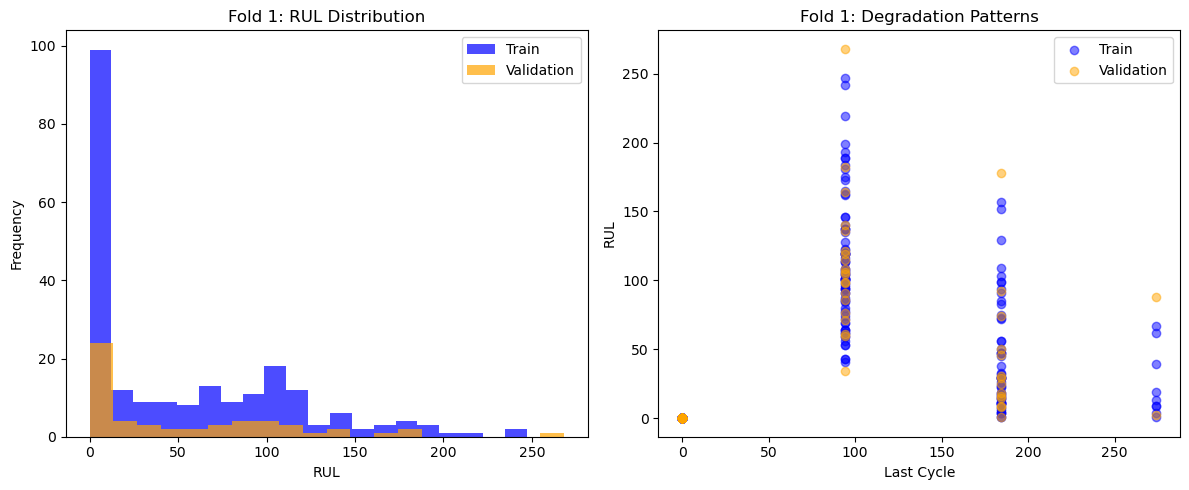

Inspecting Fold 2
  Training RUL Statistics:
count    225.000000
mean      51.497776
std       59.148418
min        0.000000
25%        0.000000
50%       29.000000
75%       98.000000
max      268.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     56.000000
mean      52.071430
std       60.128307
min        0.000000
25%        0.000000
50%       27.500000
75%       94.000000
max      247.000000
Name: RUL, dtype: float64


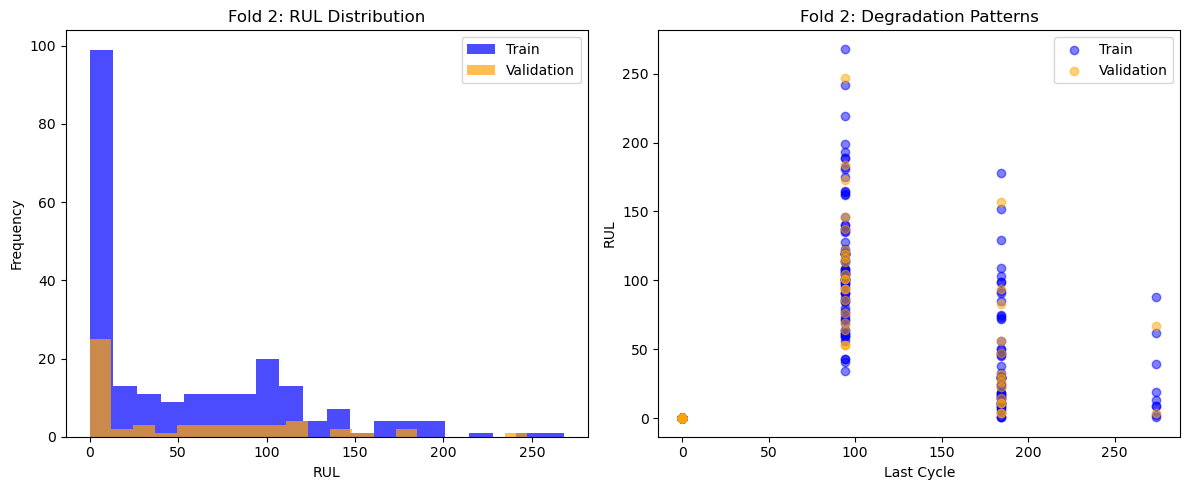

Inspecting Fold 3
  Training RUL Statistics:
count    225.000000
mean      51.528889
std       59.264038
min        0.000000
25%        0.000000
50%       26.000000
75%       95.000000
max      268.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     56.000000
mean      51.946430
std       59.664032
min        0.000000
25%        0.000000
50%       29.500000
75%       98.250000
max      242.000000
Name: RUL, dtype: float64


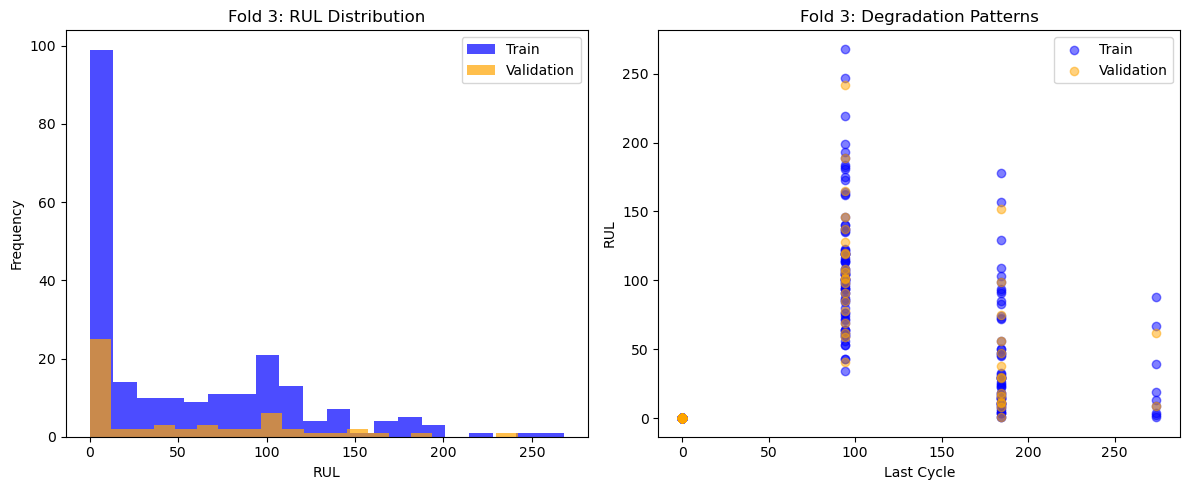

Inspecting Fold 4
  Training RUL Statistics:
count    225.000000
mean      51.639999
std       59.491508
min        0.000000
25%        0.000000
50%       26.000000
75%       95.000000
max      268.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     56.000000
mean      51.500000
std       58.735771
min        0.000000
25%        0.000000
50%       29.500000
75%       97.500000
max      219.000000
Name: RUL, dtype: float64


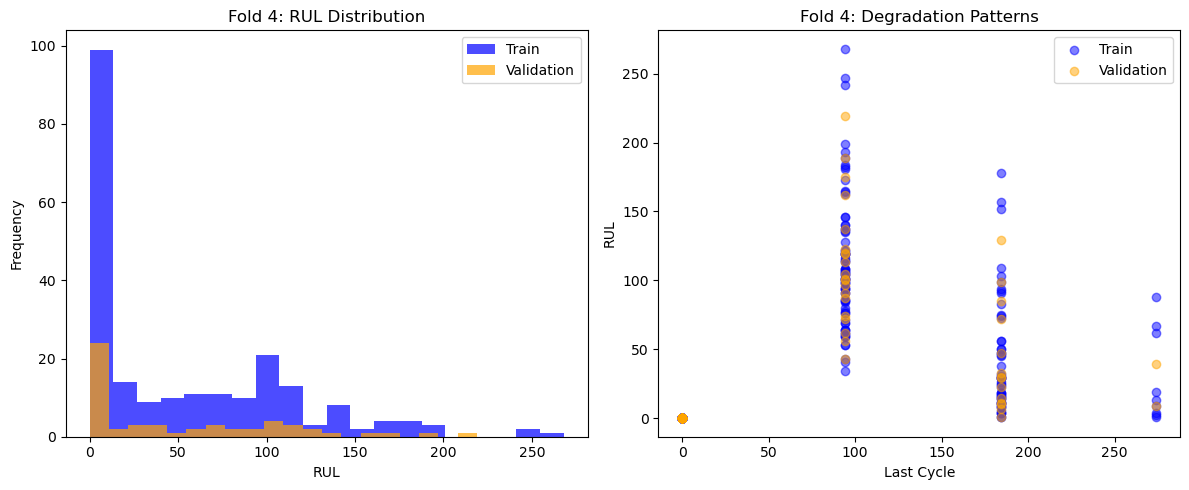

Inspecting Fold 5
  Training RUL Statistics:
count    224.000000
mean      51.924107
std       59.653862
min        0.000000
25%        0.000000
50%       29.000000
75%       97.250000
max      268.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     57.000000
mean      50.385963
std       58.073780
min        0.000000
25%        0.000000
50%       19.000000
75%       95.000000
max      199.000000
Name: RUL, dtype: float64


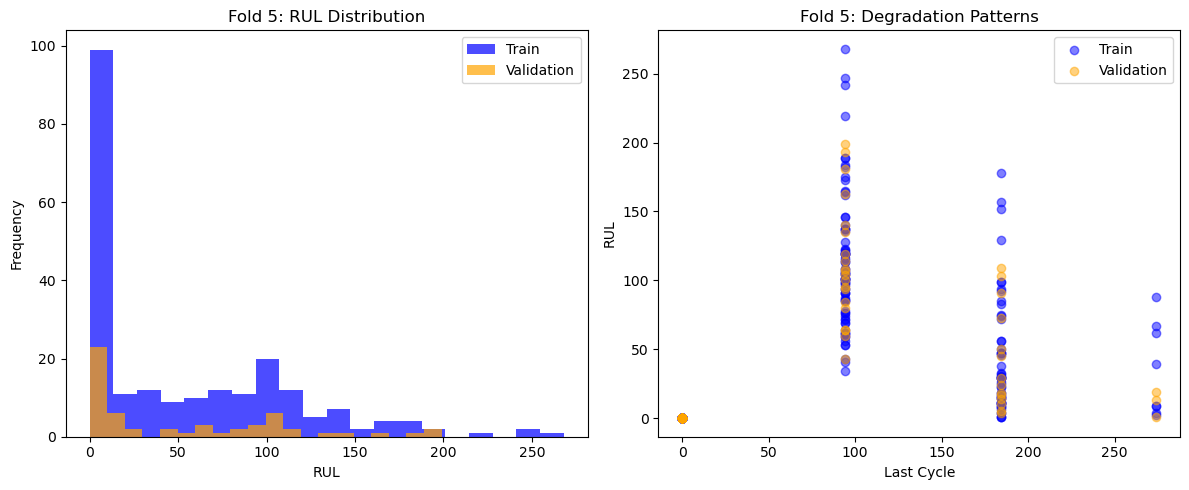

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def inspect_fold_characteristics(fold_loaders):
    """
    Inspects and visualizes RUL distribution and degradation patterns for each fold.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
    """
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Inspecting Fold {fold + 1}")
        
        # Initialize lists to collect RUL and Cycle data
        train_ruls, train_last_cycles = [], []
        val_ruls, val_last_cycles = [], []
        
        # Collect RUL and last cycles for training
        for _, targets, _, _, cycles in train_loader:
            train_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            train_last_cycles.extend(last_cycles.tolist())
        
        # Collect RUL and last cycles for validation
        for _, targets, _, _, cycles in val_loader:
            val_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            val_last_cycles.extend(last_cycles.tolist())
        
        # Convert to Pandas DataFrames for analysis
        train_df = pd.DataFrame({"RUL": train_ruls, "Last Cycle": train_last_cycles})
        val_df = pd.DataFrame({"RUL": val_ruls, "Last Cycle": val_last_cycles})
        
        # Print summary statistics
        print("  Training RUL Statistics:")
        print(train_df["RUL"].describe())
        print("  Validation RUL Statistics:")
        print(val_df["RUL"].describe())
        
        # Plot RUL distributions
        plt.figure(figsize=(12, 5))
        
        # RUL Distribution
        plt.subplot(1, 2, 1)
        plt.hist(train_df["RUL"], bins=20, alpha=0.7, label="Train", color="blue")
        plt.hist(val_df["RUL"], bins=20, alpha=0.7, label="Validation", color="orange")
        plt.xlabel("RUL")
        plt.ylabel("Frequency")
        plt.title(f"Fold {fold + 1}: RUL Distribution")
        plt.legend()

        # Degradation Patterns
        plt.subplot(1, 2, 2)
        plt.scatter(train_df["Last Cycle"], train_df["RUL"], alpha=0.5, label="Train", color="blue")
        plt.scatter(val_df["Last Cycle"], val_df["RUL"], alpha=0.5, label="Validation", color="orange")
        plt.xlabel("Last Cycle")
        plt.ylabel("RUL")
        plt.title(f"Fold {fold + 1}: Degradation Patterns")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function to inspect fold characteristics
inspect_fold_characteristics(fold_loaders)

# K-Fold evaluation and development of model as preparation for a final training

In [2]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from codebase.v5.models import TransformerRULModel
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration
input_dim = len(tabular_dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=0.001, weight_decay=1e-6, patience=10):
    """
    Train and validate the model using grouped k-fold cross-validation with early stopping.
    Summarizes metrics (e.g., RMSE, Avg MSE) across all folds.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        model_config (dict): Configuration for the model (e.g., input_dim, hidden_dim, num_layers).
        epochs (int): Maximum number of epochs to train for each fold.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs with no improvement before stopping.

    Returns:
        dict: Summary of metrics across all folds.
    """
    # Track metrics for all folds
    fold_metrics = {
        "train_rmse": [],
        "val_rmse": [],
        "train_avg_mse": [],
        "val_avg_mse": [],
    }

    # Loop over each fold
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Current Validation Fold {fold + 1}")
        
        # Initialize model, loss function, and optimizer
        model = TransformerRULModel(**model_config)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Early stopping variables
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False

        # Initialize progress bar for this fold
        total_batches = len(train_loader) * epochs
        with tqdm(total=total_batches, desc=f"Fold {fold + 1} Training", unit="batch") as pbar:
            for epoch in range(epochs):
                if early_stop:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
                
                model.train()
                train_loss = 0.0  # Track training loss
                num_train_sequences = len(train_loader.dataset)

                # Training loop
                for inputs, targets, masks, _, _ in train_loader:
                    optimizer.zero_grad()
                    inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
                    
                    # Forward pass
                    outputs = model(inputs, masks)
                    loss = criterion(outputs, targets)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                    
                    # Accumulate loss
                    train_loss += loss.item() * inputs.size(0)
                    
                    # Update progress bar
                    pbar.update(1)
                
                # Compute training metrics
                avg_train_mse = train_loss / num_train_sequences
                train_rmse = avg_train_mse ** 0.5

                # Validation loop
                model.eval()
                val_loss = 0.0
                num_val_sequences = len(val_loader.dataset)
                with torch.no_grad():
                    for inputs, targets, masks, _, _ in val_loader:
                        inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
                        
                        # Forward pass
                        outputs = model(inputs, masks)
                        loss = criterion(outputs, targets)
                        
                        # Accumulate validation loss
                        val_loss += loss.item() * inputs.size(0)
                
                # Compute validation metrics
                avg_val_mse = val_loss / num_val_sequences
                val_rmse = avg_val_mse ** 0.5

                # Check for early stopping
                if avg_val_mse < best_val_loss:
                    best_val_loss = avg_val_mse
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epoch(s).")

                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    early_stop = True

                # Print epoch metrics
                pbar.set_postfix({
                    "Epoch": f"{epoch + 1}/{epochs}",
                    "Train Loss": f"Avg MSE: {avg_train_mse:.4f}, RMSE: {train_rmse:.4f}",
                    "Val Loss:": f"Avg MSE: {avg_val_mse:.4f}, RMSE: {val_rmse:.4f}"
                })
                pbar.update(0)

        # Store fold metrics
        fold_metrics["train_rmse"].append(train_rmse)
        fold_metrics["val_rmse"].append(val_rmse)
        fold_metrics["train_avg_mse"].append(avg_train_mse)
        fold_metrics["val_avg_mse"].append(avg_val_mse)

    # Summarize metrics across all folds
    summary = {
        "mean_train_rmse": sum(fold_metrics["train_rmse"]) / len(fold_metrics["train_rmse"]),
        "mean_val_rmse": sum(fold_metrics["val_rmse"]) / len(fold_metrics["val_rmse"]),
        "mean_train_avg_mse": sum(fold_metrics["train_avg_mse"]) / len(fold_metrics["train_avg_mse"]),
        "mean_val_avg_mse": sum(fold_metrics["val_avg_mse"]) / len(fold_metrics["val_avg_mse"]),
    }

    print("\n--- k-Fold Cross-Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value:.4f}")

    return summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Define model configuration
# Define model configuration
model_config = {
    "input_dim": input_dim,
    "d_model": 96,
    "nhead": 4,
    "num_layers": 1,
    "dim_feedforward": 192,
    "dropout": 0.4333827218510093,
}

learning_rate = 0.003895180196123437
weight_decay = 6.638328586838593e-06

# Train using k-fold loaders
summary = train_and_validate_kfold(fold_loaders, model_config, epochs=50, lr=learning_rate, weight_decay=weight_decay, patience=10)

Validation Fold 1


Fold 1 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38
Validation Fold 2


Fold 2 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 48
Validation Fold 3


Fold 3 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 32
Validation Fold 4


Fold 4 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 42
Validation Fold 5


Fold 5 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 35

--- k-Fold Cross-Validation Summary ---
mean_train_rmse: 30.2889
mean_val_rmse: 34.8982
mean_train_avg_mse: 919.2871
mean_val_avg_mse: 1222.1316


As a result of our k-Fold Cross Validation we can see that our fold setup yields an **average validation RMSE** of 34.8982.

# K-Fold evaluation: Using Optuna for hyperparameter search
Let's use Optuna for an efficient hyperparameter search.

In [ ]:
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Calls the existing train_and_validate_kfold function.
    """
    # Ensure transformer_d_model is divisible by transformer_nhead
    nhead = trial.suggest_int("nhead", 2, 8, step=2)
    d_model = trial.suggest_int(
        "d_model", nhead * 16, nhead * 32, step=nhead * 8
    )
    
    dim_feedworward = trial.suggest_int("dim_feedforward", 128, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Create the model configuration for the trial
    # input_dim, hidden_dim=256, num_heads=3, num_layers=1, dropout=0.3
    # Define model configuration
    model_config = {
        "input_dim": input_dim,
        "d_model": d_model,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_feedworward,
        "dropout": dropout,
    }

    # Call your existing train_and_validate_kfold function
    summary = train_and_validate_kfold(
        fold_loaders=fold_loaders,
        model_config=model_config,
        epochs=100,  # Fewer epochs for faster tuning
        lr=lr,
        weight_decay=weight_decay,
        patience=10  # Early stopping patience
    )

    # Return the mean validation RMSE as the objective value
    return summary["mean_val_rmse"]

# Optuna study configuration
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Number of trials for hyperparameter tuning

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# Training without K-Fold

In [3]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

from codebase.v5.models import TransformerRULModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = len(tabular_dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_single_run(
    train_loader, val_loader,
    model_config,
    epochs=500,
    lr=0.001,
    weight_decay=1e-6,
    patience=10,
    model_path="saved_weights/model.pth",
    loss_type="mse",  # "mse" or "huber"
):
    """
    Train and validate the model using a *single* train/validation set (no k-fold).
    Summarizes metrics (e.g., RMSE, Avg Loss) for this single train/val split.

    Args:
        fold_loaders (list): List containing a single (train_loader, val_loader) tuple.
        model_config (dict): Configuration for the model (e.g., input_dim, d_model, num_layers).
        epochs (int): Maximum number of epochs to train.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for regularization.
        patience (int): Number of epochs with no improvement before stopping.
        model_path (str): Where to save the best model weights.
        loss_type (str): "mse" or "huber". Determines which loss function is used.

    Returns:
        model (nn.Module): Trained model (best validation loss).
        summary (dict): Summary of metrics for the single train/val run.
    """

    # We'll use only the first tuple from fold_loaders
    
    print("Using standard train/validation approach instead of k-fold.")

    # ======================
    #  Set up model & loss
    # ======================
    model = TransformerRULModel(**model_config).to(device)

    # Choose the loss function based on loss_type
    if loss_type.lower() == "mse":
        criterion = nn.MSELoss()
    elif loss_type.lower() == "huber":
        criterion = nn.HuberLoss(delta=1.0)
    else:
        raise ValueError(f"Invalid loss_type: {loss_type}. Choose 'mse' or 'huber'.")

    # AdamW optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Track metrics for this single run
    fold_metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_rmse": [],
        "val_rmse": [],
    }

    # Early stopping variables
    best_val_loss = float("inf")
    best_epoch = 0
    epochs_no_improve = 0
    early_stop = False

    # ======================
    #  Training Loop
    # ======================
    total_batches = len(train_loader) * epochs
    with tqdm(total=total_batches, desc="Training", unit="batch") as pbar:
        for epoch in range(epochs):
            if early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break

            # ---------------------------
            # 1. Training
            # ---------------------------
            model.train()
            train_loss_accum = 0.0
            train_predictions = []
            train_targets_all = []

            for inputs, targets, masks, _, _ in train_loader:
                optimizer.zero_grad()

                inputs = inputs.to(device)
                targets = targets.to(device)
                masks = masks.to(device)

                outputs = model(inputs, masks)  # (batch_size,)

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                # Accumulate for final averaging
                batch_size = inputs.size(0)
                train_loss_accum += loss.item() * batch_size

                # For RMSE calculation, store predictions & targets
                train_predictions.append(outputs.detach().cpu())
                train_targets_all.append(targets.detach().cpu())

                pbar.update(1)

            # Compute average training loss
            num_train_samples = len(train_loader.dataset)
            avg_train_loss = train_loss_accum / num_train_samples

            # Compute training RMSE
            train_predictions = torch.cat(train_predictions, dim=0)
            train_targets_all = torch.cat(train_targets_all, dim=0)
            train_rmse = torch.sqrt(torch.mean((train_predictions - train_targets_all) ** 2)).item()

            # ---------------------------
            # 2. Validation
            # ---------------------------
            model.eval()
            val_loss_accum = 0.0
            val_predictions = []
            val_targets_all = []

            with torch.no_grad():
                for inputs, targets, masks, _, _ in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    masks = masks.to(device)

                    outputs = model(inputs, masks)
                    loss = criterion(outputs, targets)

                    batch_size = inputs.size(0)
                    val_loss_accum += loss.item() * batch_size

                    val_predictions.append(outputs.cpu())
                    val_targets_all.append(targets.cpu())

            num_val_samples = len(val_loader.dataset)
            avg_val_loss = val_loss_accum / num_val_samples

            val_predictions = torch.cat(val_predictions, dim=0)
            val_targets_all = torch.cat(val_targets_all, dim=0)
            val_rmse = torch.sqrt(torch.mean((val_predictions - val_targets_all) ** 2)).item()

            # ---------------------------
            # 3. Early Stopping Logic
            # ---------------------------
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_val_rmse = val_rmse

                epochs_no_improve = 0
                best_epoch = epoch + 1
                torch.save(model.state_dict(), model_path)
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                early_stop = True

            # Record stats
            fold_metrics["train_loss"].append(avg_train_loss)
            fold_metrics["val_loss"].append(avg_val_loss)
            fold_metrics["train_rmse"].append(train_rmse)
            fold_metrics["val_rmse"].append(val_rmse)

            # ---------------------------
            # 4. TQDM Logging
            # ---------------------------
            pbar.set_postfix({
                "Epoch": f"{epoch + 1}/{epochs}",
                "Train Loss": f"{avg_train_loss:.4f}",
                "Train RMSE": f"{train_rmse:.4f}",
                "Val Loss": f"{avg_val_loss:.4f}",
                "Val RMSE": f"{val_rmse:.4f}"
            })
            pbar.update(0)

    # ======================
    #  Final Summary
    # ======================
    # Load best model
    model.load_state_dict(torch.load(model_path))

    # Summaries
    summary = {
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "best_val_rmse": best_val_rmse,
        "final_train_loss": fold_metrics["train_loss"][-1] if fold_metrics["train_loss"] else None,
        "final_val_loss": fold_metrics["val_loss"][-1] if fold_metrics["val_loss"] else None,
        "final_train_rmse": fold_metrics["train_rmse"][-1] if fold_metrics["train_rmse"] else None,
        "final_val_rmse": fold_metrics["val_rmse"][-1] if fold_metrics["val_rmse"] else None,
    }

    print("\n--- Train/Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value}")

    print(f"\nTraining complete. Best model loaded (epoch {best_epoch}).")

    return model, summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Best hyperparameters: 
#   {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4333827218510093, 
#       'lr': 0.003895180196123437, 'weight_decay': 6.638328586838593e-06}
# Best validation RMSE: 34.41191377372541

#Best hyperparameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 448, 'num_layers': 1, 
# 'dropout': 0.1003562785910157, 'lr': 0.0007065882362962968, 'weight_decay': 1.2378678290714463e-06}
#Best validation RMSE: 29.802541732788086


# Define model configuration
model_config = {
    "input_dim": input_dim,
    "d_model": 256,
    "nhead": 8,
    "num_layers": 1,
    "dim_feedforward": 448,
    "dropout": 0.1003562785910157,
}

learning_rate = 0.0007065882362962968
weight_decay = 1.2378678290714463e-06

train_loader, val_loader = fold_loaders[0]

# Train using k-fold loaders
model, summary = train_and_validate_single_run(
        train_loader=train_loader, val_loader=val_loader,
        model_config=model_config,
        epochs=150, 
        lr=learning_rate,
        weight_decay=weight_decay,
        patience=10,
        loss_type="mse"
    )

Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 144

--- Train/Validation Summary ---
best_epoch: 133
best_val_loss: 619.9338989257812
best_val_rmse: 24.8984699

/tmp/ipykernel_97383/3161191942.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## **Difference Between MSE and Huber Loss and Implications on Validation Loss and RMSE**

Both **Mean Squared Error (MSE)** and **Huber Loss** are used in regression tasks, but they handle errors differently, particularly when it comes to **outliers**.

---

### **1. Mean Squared Error (MSE)**
- **Formula**:
  $$
  L_{\text{MSE}} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2
  $$
- **Characteristics**:
  - Penalizes **larger errors more severely** because the error is squared.
  - Sensitive to **outliers**: A single large error can dominate the loss, destabilizing training.
  - Best for data where outliers are rare or unimportant.
- **Implications on Metrics**:
  - **Validation Loss**:
    - Directly reflects the average of squared errors.
    - Sensitive to outliers; validation loss can become large if the test set contains outliers.
  - **Validation RMSE**:
    - RMSE is derived from MSE:  
      $$
      \text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2}
      $$
    - RMSE magnifies large errors (due to the square root), making it more sensitive to outliers than MAE.

---

### **2. Huber Loss**
- **Formula**:
  $$
  L_{\text{Huber}} =
  \begin{cases}
    \frac{1}{2} (\hat{y}_i - y_i)^2 & \text{if } |\hat{y}_i - y_i| \leq \delta, \\
    \delta \cdot |\hat{y}_i - y_i| - \frac{1}{2} \delta^2 & \text{otherwise.}
  \end{cases}
  $$
  where $\delta$ is the threshold for determining whether an error is small or large.
  
- **Characteristics**:
  - **Quadratic for small errors** ($ |error| \leq \delta $): Similar to MSE for small errors.
  - **Linear for large errors** ($ |error| > \delta $): Less sensitive to outliers compared to MSE.
  - The transition point is controlled by $\delta$ (default is 1.0 in PyTorch).
- **Implications on Metrics**:
  - **Validation Loss**:
    - Huber Loss will be smaller than MSE if the dataset contains large outliers, as large errors are penalized linearly instead of quadratically.
    - Loss reflects a combination of MSE (for small errors) and MAE-like behavior (for large errors).
  - **Validation RMSE**:
    - RMSE is still calculated from squared residuals, so it remains sensitive to outliers.
    - There might be a **mismatch** between the Huber Loss (less sensitive to outliers) and RMSE (still sensitive to outliers).

---

### **Key Differences in Behavior**

| **Aspect**            | **MSE**                                          | **Huber Loss**                                   |
|------------------------|--------------------------------------------------|-------------------------------------------------|
| **Outlier Sensitivity**| Very sensitive to large errors                   | Less sensitive; outlier impact reduced linearly |
| **Validation Loss**    | Can be dominated by outliers                     | More robust; reflects balanced error behavior   |
| **Validation RMSE**    | Sensitive to outliers (matches MSE behavior)     | Remains sensitive to outliers despite Huber Loss|

---

### **Implications for Validation Metrics**

#### **1. Validation Loss**
- **When using Huber Loss**:
  - Validation loss reflects the mix of quadratic (small errors) and linear (large errors) penalties.
  - Outliers have **less influence** compared to MSE.
  - You may notice that validation loss is smaller with Huber Loss if outliers are present.

- **When using MSE**:
  - Validation loss will directly reflect the squared residuals, with **large penalties** for outliers.
  - If outliers are present, MSE will likely result in larger validation losses compared to Huber Loss.

#### **2. Validation RMSE**
- **Independent of Loss Function**:
  - RMSE always uses squared residuals.
  - If there are outliers, RMSE will still be inflated regardless of whether the model was trained with MSE or Huber Loss.
- **Mismatch Possibility**:
  - If you train with Huber Loss (less sensitive to outliers) but evaluate using RMSE (sensitive to outliers), you may observe higher RMSE than expected based on the validation loss.

---

### **When to Use MSE vs. Huber Loss**

| **Use MSE**                           | **Use Huber Loss**                        |
|---------------------------------------|-------------------------------------------|
| When outliers are rare or negligible. | When the dataset contains significant outliers. |
| When penalizing large errors is crucial.| When robustness to outliers is important. |
| When you want RMSE to match training. | When you care more about average predictive behavior. |

---

### **Summary**
- **Validation Loss** reflects the behavior of the loss function used in training:
  - MSE is more sensitive to outliers than Huber Loss.
- **Validation RMSE** is always computed using squared residuals, so it remains sensitive to outliers, even if Huber Loss is used for training.
- When using Huber Loss, expect a potential **mismatch** between the validation loss and RMSE due to differing sensitivity to outliers.


In [8]:
# Save the dictionary
torch.save(model_config, config_path)

# Save the model state dictionary for AdvancedContentRecommendationNet
torch.save({
    'model_state_dict': model.state_dict(),    
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'overlap': overlap,
    'sequence_length': sequence_length,
    'batch_size': batch_size,
}, model_path)

print(f"Model saved to {model_path}")

Model saved to saved_weights/model.pth


# Training without K-Fold: Optuna

In [4]:
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Calls the existing train_and_validate_kfold function.
    """
        
    # Ensure transformer_d_model is divisible by transformer_nhead
    nhead = trial.suggest_int("nhead", 2, 8, step=2)
    d_model = trial.suggest_int(
        "d_model", nhead * 16, nhead * 32, step=nhead * 8
    )
    
    dim_feedworward = trial.suggest_int("dim_feedforward", 128, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Define model configuration
    model_config = {
        "input_dim": input_dim,
        "d_model": d_model,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_feedworward,
        "dropout": dropout,
    }

    # Call your existing train_and_validate_kfold function
    _, summary = train_and_validate_single_run(
        train_loader=fold_loaders[0][0],
        val_loader=fold_loaders[0][1],
        model_config=model_config,
        epochs=50,  # Fewer epochs for faster tuning
        lr=lr,
        weight_decay=weight_decay,
        patience=10  # Early stopping patience
    )

    # Return the mean validation RMSE as the objective value
    return summary["final_val_rmse"]

# Optuna study configuration
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Number of trials for hyperparameter tuning

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2025-01-16 10:45:28,893] A new study created in memory with name: no-name-957b5d06-0450-4eba-a006-532672eb8aba


Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327489/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
/tmp/ipykernel_9428/3161191942.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explici


--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 7292.37939453125
best_val_rmse: 85.39543151855469
final_train_loss: 7127.043541217672
final_val_loss: 7292.37939453125
final_train_rmse: 84.42182159423828
final_val_rmse: 85.39543151855469

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 10:47:21,562] Trial 1 finished with value: 35.658477783203125 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 320, 'num_layers': 3, 'dropout': 0.21257289767210152, 'lr': 0.0027907410320924878, 'weight_decay': 3.6538160595710514e-06}. Best is trial 1 with value: 35.658477783203125.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 34

--- Train/Validation Summary ---
best_epoch: 23
best_val_loss: 1268.5848388671875
best_val_rmse: 35.6171989440918
final_train_loss: 812.5128258014547
final_val_loss: 1271.527099609375
final_train_rmse: 28.50461196899414
final_val_rmse: 35.658477783203125

Training complete. Best model loaded (epoch 23).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 10:48:28,096] Trial 2 finished with value: 93.34913635253906 and parameters: {'nhead': 6, 'd_model': 96, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.10130586611119274, 'lr': 0.00022875276637802745, 'weight_decay': 1.3487486974301722e-05}. Best is trial 1 with value: 35.658477783203125.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 8714.060546875
best_val_rmse: 93.34913635253906
final_train_loss: 8391.460378502155
final_val_loss: 8714.060546875
final_train_rmse: 91.60491180419922
final_val_rmse: 93.34913635253906

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 10:49:25,283] Trial 3 finished with value: 35.83006286621094 and parameters: {'nhead': 2, 'd_model': 32, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.12187187535424973, 'lr': 0.0076559160833497356, 'weight_decay': 3.185977842709043e-06}. Best is trial 1 with value: 35.658477783203125.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 45

--- Train/Validation Summary ---
best_epoch: 34
best_val_loss: 1098.5098876953125
best_val_rmse: 33.143775939941406
final_train_loss: 778.7461871969289
final_val_loss: 1283.79345703125
final_train_rmse: 27.906024932861328
final_val_rmse: 35.83006286621094

Training complete. Best model loaded (epoch 34).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 10:50:31,907] Trial 4 finished with value: 55.38187789916992 and parameters: {'nhead': 4, 'd_model': 64, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.32981189431242497, 'lr': 0.0009508062184096529, 'weight_decay': 9.546137023836632e-05}. Best is trial 1 with value: 35.658477783203125.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 3067.15234375
best_val_rmse: 55.38187789916992
final_train_loss: 2917.6335230334053
final_val_loss: 3067.15234375
final_train_rmse: 54.0151252746582
final_val_rmse: 55.38187789916992

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 10:51:39,819] Trial 5 finished with value: 89.52456665039062 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 128, 'num_layers': 2, 'dropout': 0.33872842678742987, 'lr': 0.00010079164192238809, 'weight_decay': 5.802472192990997e-05}. Best is trial 1 with value: 35.658477783203125.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 8014.6484375
best_val_rmse: 89.52456665039062
final_train_loss: 7818.81060075431
final_val_loss: 8014.6484375
final_train_rmse: 88.42404174804688
final_val_rmse: 89.52456665039062

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 10:52:46,733] Trial 6 finished with value: 89.36243438720703 and parameters: {'nhead': 2, 'd_model': 64, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.47379846247894264, 'lr': 0.0004273963498808898, 'weight_decay': 7.786806677815064e-06}. Best is trial 1 with value: 35.658477783203125.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 7985.64306640625
best_val_rmse: 89.36243438720703
final_train_loss: 7762.992625269397
final_val_loss: 7985.64306640625
final_train_rmse: 88.10784912109375
final_val_rmse: 89.36243438720703

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 10:53:29,440] Trial 7 finished with value: 35.560115814208984 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.16334448703805404, 'lr': 0.0013205299491193944, 'weight_decay': 6.814576807940855e-05}. Best is trial 7 with value: 35.560115814208984.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 34

--- Train/Validation Summary ---
best_epoch: 23
best_val_loss: 1213.625
best_val_rmse: 34.837120056152344
final_train_loss: 425.05606942012395
final_val_loss: 1264.52197265625
final_train_rmse: 20.616886138916016
final_val_rmse: 35.560115814208984

Training complete. Best model loaded (epoch 23).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-16 10:54:35,840] Trial 8 finished with value: 35.11940002441406 and parameters: {'nhead': 2, 'd_model': 64, 'dim_feedforward': 448, 'num_layers': 1, 'dropout': 0.2402938762454376, 'lr': 0.001848634139443336, 'weight_decay': 1.2497262447032477e-05}. Best is trial 8 with value: 35.11940002441406.


No improvement for 1 epoch(s).

--- Train/Validation Summary ---
best_epoch: 49
best_val_loss: 1219.041748046875
best_val_rmse: 34.91477966308594
final_train_loss: 820.1900146484375
final_val_loss: 1233.372314453125
final_train_rmse: 28.638959884643555
final_val_rmse: 35.11940002441406

Training complete. Best model loaded (epoch 49).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 10:55:04,474] Trial 9 finished with value: 55.60214614868164 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 256, 'num_layers': 3, 'dropout': 0.20864816624240873, 'lr': 0.007150775383369419, 'weight_decay': 1.6001224419562254e-06}. Best is trial 8 with value: 35.11940002441406.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 22

--- Train/Validation Summary ---
best_epoch: 11
best_val_loss: 2048.22509765625
best_val_rmse: 45.25731658935547
final_train_loss: 1815.548685008082
final_val_loss: 3091.598876953125
final_train_rmse: 42.609256744384766
final_val_rmse: 55.60214614868164

Training complete. Best model loaded (epoch 11).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 10:56:02,658] Trial 10 finished with value: 37.855743408203125 and parameters: {'nhead': 4, 'd_model': 64, 'dim_feedforward': 512, 'num_layers': 4, 'dropout': 0.24910332011220224, 'lr': 0.002962016859881158, 'weight_decay': 1.9147686132350173e-05}. Best is trial 8 with value: 35.11940002441406.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 43

--- Train/Validation Summary ---
best_epoch: 32
best_val_loss: 1170.123291015625
best_val_rmse: 34.20706558227539
final_train_loss: 886.8460162984913
final_val_loss: 1433.057373046875
final_train_rmse: 29.77996063232422
final_val_rmse: 37.855743408203125

Training complete. Best model loaded (epoch 32).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 10:56:39,161] Trial 11 finished with value: 43.095672607421875 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.16374156049395547, 'lr': 0.002039513000442568, 'weight_decay': 2.3603287644861357e-05}. Best is trial 8 with value: 35.11940002441406.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 28

--- Train/Validation Summary ---
best_epoch: 17
best_val_loss: 1304.1514892578125
best_val_rmse: 36.113037109375
final_train_loss: 808.8610831425108
final_val_loss: 1857.237060546875
final_train_rmse: 28.44048309326172
final_val_rmse: 43.095672607421875

Training complete. Best model loaded (epoch 17).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 10:57:36,555] Trial 12 finished with value: 37.49472427368164 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 448, 'num_layers': 1, 'dropout': 0.26794664185305506, 'lr': 0.0015973408429093778, 'weight_decay': 6.962815478252563e-06}. Best is trial 8 with value: 35.11940002441406.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 44

--- Train/Validation Summary ---
best_epoch: 33
best_val_loss: 1231.4510498046875
best_val_rmse: 35.092037200927734
final_train_loss: 437.18787210398705
final_val_loss: 1405.8541259765625
final_train_rmse: 20.909038543701172
final_val_rmse: 37.49472427368164

Training complete. Best model loaded (epoch 33).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).


[I 2025-01-16 10:58:45,688] Trial 13 finished with value: 34.43501663208008 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.1681161145583071, 'lr': 0.0005061515084944057, 'weight_decay': 3.240908172165209e-05}. Best is trial 13 with value: 34.43501663208008.


No improvement for 5 epoch(s).

--- Train/Validation Summary ---
best_epoch: 45
best_val_loss: 1136.5830078125
best_val_rmse: 33.7132453918457
final_train_loss: 693.7994814116379
final_val_loss: 1185.7701416015625
final_train_rmse: 26.340072631835938
final_val_rmse: 34.43501663208008

Training complete. Best model loaded (epoch 45).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 10:59:52,802] Trial 14 finished with value: 84.5206527709961 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.31418923423325545, 'lr': 0.00043684484576550964, 'weight_decay': 2.951149514087627e-05}. Best is trial 13 with value: 34.43501663208008.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 7143.7412109375
best_val_rmse: 84.5206527709961
final_train_loss: 6985.657825969827
final_val_loss: 7143.7412109375
final_train_rmse: 83.58024597167969
final_val_rmse: 84.5206527709961

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 11:01:00,770] Trial 15 finished with value: 66.48810577392578 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 320, 'num_layers': 3, 'dropout': 0.187589663670677, 'lr': 0.0004133235964558729, 'weight_decay': 3.40757032899749e-05}. Best is trial 13 with value: 34.43501663208008.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 4420.66845703125
best_val_rmse: 66.48810577392578
final_train_loss: 4276.768756734914
final_val_loss: 4420.66845703125
final_train_rmse: 65.39701080322266
final_val_rmse: 66.48810577392578

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 11:02:08,195] Trial 16 finished with value: 36.30607986450195 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 448, 'num_layers': 4, 'dropout': 0.3853502759382405, 'lr': 0.0006480122037288435, 'weight_decay': 1.329233100567609e-05}. Best is trial 13 with value: 34.43501663208008.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 49

--- Train/Validation Summary ---
best_epoch: 38
best_val_loss: 1167.6669921875
best_val_rmse: 34.171142578125
final_train_loss: 737.073088126347
final_val_loss: 1318.1317138671875
final_train_rmse: 27.149089813232422
final_val_rmse: 36.30607986450195

Training complete. Best model loaded (epoch 38).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 11:03:15,711] Trial 17 finished with value: 101.5266342163086 and parameters: {'nhead': 2, 'd_model': 48, 'dim_feedforward': 192, 'num_layers': 2, 'dropout': 0.256183820686829, 'lr': 0.00020368396370560481, 'weight_decay': 5.022695865207742e-06}. Best is trial 13 with value: 34.43501663208008.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 10307.6572265625
best_val_rmse: 101.5266342163086
final_train_loss: 9901.48018588362
final_val_loss: 10307.6572265625
final_train_rmse: 99.50617980957031
final_val_rmse: 101.5266342163086

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).


[I 2025-01-16 11:04:25,011] Trial 18 finished with value: 35.757022857666016 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 384, 'num_layers': 2, 'dropout': 0.13038040897130626, 'lr': 0.00411220845706715, 'weight_decay': 1.032007007797379e-06}. Best is trial 13 with value: 34.43501663208008.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1278.5648193359375
best_val_rmse: 35.757022857666016
final_train_loss: 299.2701103473532
final_val_loss: 1278.5648193359375
final_train_rmse: 17.29942512512207
final_val_rmse: 35.757022857666016

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 11:05:38,775] Trial 19 finished with value: 87.83821868896484 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 448, 'num_layers': 3, 'dropout': 0.2343940419782527, 'lr': 0.00022317983766231652, 'weight_decay': 1.2109866200575204e-05}. Best is trial 13 with value: 34.43501663208008.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 7715.552734375
best_val_rmse: 87.83821868896484
final_train_loss: 7416.435088900862
final_val_loss: 7715.552734375
final_train_rmse: 86.11872100830078
final_val_rmse: 87.83821868896484

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 11:06:46,238] Trial 20 finished with value: 34.1253662109375 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.2969086900141115, 'lr': 0.0006499263720145911, 'weight_decay': 2.0321858504547665e-05}. Best is trial 20 with value: 34.1253662109375.


No improvement for 10 epoch(s).
Early stopping triggered.

--- Train/Validation Summary ---
best_epoch: 40
best_val_loss: 1091.5758056640625
best_val_rmse: 33.039005279541016
final_train_loss: 570.243100080819
final_val_loss: 1164.5406494140625
final_train_rmse: 23.879762649536133
final_val_rmse: 34.1253662109375

Training complete. Best model loaded (epoch 40).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-16 11:07:55,873] Trial 21 finished with value: 33.25065231323242 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.28013765316749745, 'lr': 0.0005921478547415861, 'weight_decay': 1.8817498894207575e-05}. Best is trial 21 with value: 33.25065231323242.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
best_epoch: 48
best_val_loss: 1093.8504638671875
best_val_rmse: 33.07341003417969
final_train_loss: 597.6001902613147
final_val_loss: 1105.6060791015625
final_train_rmse: 24.44586181640625
final_val_rmse: 33.25065231323242

Training complete. Best model loaded (epoch 48).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).


[I 2025-01-16 11:09:03,894] Trial 22 finished with value: 34.537925720214844 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.2865393401440353, 'lr': 0.0006925652075711333, 'weight_decay': 2.1288747819418427e-05}. Best is trial 21 with value: 33.25065231323242.


No improvement for 5 epoch(s).

--- Train/Validation Summary ---
best_epoch: 45
best_val_loss: 1169.0050048828125
best_val_rmse: 34.190711975097656
final_train_loss: 459.6306880556304
final_val_loss: 1192.8682861328125
final_train_rmse: 21.43899917602539
final_val_rmse: 34.537925720214844

Training complete. Best model loaded (epoch 45).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 11:10:14,242] Trial 23 finished with value: 49.00241470336914 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 192, 'num_layers': 2, 'dropout': 0.3824154913497028, 'lr': 0.0003186931202974497, 'weight_decay': 3.8970376621294475e-05}. Best is trial 21 with value: 33.25065231323242.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 2401.236572265625
best_val_rmse: 49.00241470336914
final_train_loss: 2362.4578630118535
final_val_loss: 2401.236572265625
final_train_rmse: 48.60512161254883
final_val_rmse: 49.00241470336914

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).


[I 2025-01-16 11:11:21,395] Trial 24 finished with value: 35.51943588256836 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.35852609889556514, 'lr': 0.0006117006174157438, 'weight_decay': 1.835322148861615e-05}. Best is trial 21 with value: 33.25065231323242.


No improvement for 5 epoch(s).

--- Train/Validation Summary ---
best_epoch: 45
best_val_loss: 1110.853271484375
best_val_rmse: 33.329463958740234
final_train_loss: 599.3076239224138
final_val_loss: 1261.630126953125
final_train_rmse: 24.48076057434082
final_val_rmse: 35.51943588256836

Training complete. Best model loaded (epoch 45).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 11:12:15,924] Trial 25 finished with value: 38.93362045288086 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.2997322623819121, 'lr': 0.001143538587650346, 'weight_decay': 2.6975159135825348e-05}. Best is trial 21 with value: 33.25065231323242.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 41

--- Train/Validation Summary ---
best_epoch: 30
best_val_loss: 1293.77978515625
best_val_rmse: 35.96915054321289
final_train_loss: 517.0944697939117
final_val_loss: 1515.8270263671875
final_train_rmse: 22.739709854125977
final_val_rmse: 38.93362045288086

Training complete. Best model loaded (epoch 30).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 11:13:24,408] Trial 26 finished with value: 60.82161331176758 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.4244523828478942, 'lr': 0.0003222659099249261, 'weight_decay': 5.7865264327983833e-05}. Best is trial 21 with value: 33.25065231323242.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 3699.2685546875
best_val_rmse: 60.82161331176758
final_train_loss: 3671.8020339439654
final_val_loss: 3699.2685546875
final_train_rmse: 60.59539794921875
final_val_rmse: 60.82161331176758

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[I 2025-01-16 11:14:33,848] Trial 27 finished with value: 91.09153747558594 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.2809700325534894, 'lr': 0.00014726842263767053, 'weight_decay': 1.6559733735981937e-05}. Best is trial 21 with value: 33.25065231323242.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 8297.6669921875
best_val_rmse: 91.09153747558594
final_train_loss: 8106.557819234914
final_val_loss: 8297.6669921875
final_train_rmse: 90.03642272949219
final_val_rmse: 91.09153747558594

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-16 11:15:30,768] Trial 28 finished with value: 35.623111724853516 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 320, 'num_layers': 2, 'dropout': 0.1716495129731625, 'lr': 0.0007493501472467328, 'weight_decay': 8.573556368006856e-06}. Best is trial 21 with value: 33.25065231323242.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 42

--- Train/Validation Summary ---
best_epoch: 31
best_val_loss: 1074.5450439453125
best_val_rmse: 32.78025436401367
final_train_loss: 534.38392460264
final_val_loss: 1269.0059814453125
final_train_rmse: 23.11674690246582
final_val_rmse: 35.623111724853516

Training complete. Best model loaded (epoch 31).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).


[I 2025-01-16 11:16:38,816] Trial 29 finished with value: 33.835479736328125 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 2, 'dropout': 0.20776254668251715, 'lr': 0.0008205678436861176, 'weight_decay': 4.718803210287886e-05}. Best is trial 21 with value: 33.25065231323242.


No improvement for 4 epoch(s).

--- Train/Validation Summary ---
best_epoch: 46
best_val_loss: 1050.86083984375
best_val_rmse: 32.41698455810547
final_train_loss: 611.8012518521012
final_val_loss: 1144.839599609375
final_train_rmse: 24.734617233276367
final_val_rmse: 33.835479736328125

Training complete. Best model loaded (epoch 46).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).


[I 2025-01-16 11:17:47,587] Trial 30 finished with value: 35.728599548339844 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 128, 'num_layers': 3, 'dropout': 0.20190163162752364, 'lr': 0.000898130881193464, 'weight_decay': 9.51950496362619e-05}. Best is trial 21 with value: 33.25065231323242.


No improvement for 5 epoch(s).

--- Train/Validation Summary ---
best_epoch: 45
best_val_loss: 1163.4486083984375
best_val_rmse: 34.1093635559082
final_train_loss: 700.4110258957435
final_val_loss: 1276.5328369140625
final_train_rmse: 26.46527862548828
final_val_rmse: 35.728599548339844

Training complete. Best model loaded (epoch 45).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

[W 2025-01-16 11:18:46,639] Trial 31 failed with parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 192, 'num_layers': 2, 'dropout': 0.22732813634505653, 'lr': 0.0005365061798189081, 'weight_decay': 4.761324655064289e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_9428/3015086923.py", line 32, in objective
    _, summary = train_and_validate_single_run(
  File "/tmp/ipykernel_9428/3161191942.py", line 97, in train_and_validate_single_run
    for inputs, targets, masks, _, _ in train_loader:
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/utils/data/dataloade

KeyboardInterrupt: 

# Evaluate the model with the test loader

In [9]:
from codebase.v5.models import TransformerRULModel
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "saved_weights/"
config_path = os.path.join(model_path, "config.pth")
model_path = os.path.join(model_path, "model.pth")

config = torch.load(config_path)

# Reinitialize the model architecture
checkpoint = torch.load(model_path, weights_only=True)

# RecommendationNet model
loaded_model = TransformerRULModel(**config).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

/tmp/ipykernel_97383/2730750230.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(config_path)


TransformerRULModel(
  (input_projection): Linear(in_features=38, out_features=256, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=448, bias=True)
        (dropout): Dropout(p=0.1003562785910157, inplace=False)
        (linear2): Linear(in_features=448, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1003562785910157, inplace=False)
        (dropout2): Dropout(p=0.1003562785910157, inplace=False)
      )
    )
  )
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh(

In [10]:
import pandas as pd

# Load the RUL file
rul_file_path = "./data/CMAPSSData/RUL_FD001.txt"  # Adjust the path if needed
rul_df = pd.read_csv(rul_file_path, header=None, names=["RUL"])

# RUL values for each engine
rul_values = rul_df["RUL"].values  # Shape: (num_engines,)

In [11]:
import torch.nn.functional as F

def evaluate_model_final_sequence(model, test_loader, rul_values, device="cpu"):
    """
    Evaluate the model on the test set while persisting engine-level data across batches.
    
    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): Test DataLoader, returning sequences.
        rul_values (numpy.ndarray): Array of ground-truth RUL values for the test set.
        device (str): Device to run the evaluation on ("cpu" or "cuda").
    
    Returns:
        float: RMSE score for the test set.
    """
    model.eval()
    
    # Persistent dictionaries for tracking final sequences across all batches
    engine_id_to_best_cycle = {}
    engine_id_to_best_pred = {}
    
    with torch.no_grad():
        for (features, masks, engine_ids, cycles) in test_loader:
            # Move data to the device
            features, masks = features.to(device), masks.to(device)
            
            # Predict RUL for each sequence
            outputs = model(features, masks)  # Shape: (batch_size,)

            # Process each sequence in the batch
            for i in range(len(engine_ids)):
                e_id = int(engine_ids[i].item()) - 1  # Convert 1-based engine ID to 0-based index
                cycle_array = cycles[i].cpu().numpy()  # Extract cycle array for this sequence
                max_cycle_in_window = cycle_array.max()  # Find the highest cycle in this sequence
                
                # Update the persistent dictionary if this sequence is more "final"
                if (e_id not in engine_id_to_best_cycle) or (max_cycle_in_window > engine_id_to_best_cycle[e_id]):
                    engine_id_to_best_cycle[e_id] = max_cycle_in_window
                    engine_id_to_best_pred[e_id] = outputs[i].item()

    # Finalize predictions and compare with ground truth
    predictions = []
    ground_truth = []
    for e_id, pred in engine_id_to_best_pred.items():
        predictions.append(pred)
        ground_truth.append(rul_values[e_id])  # Match RUL from the ground truth file

    # Compute RMSE
    predictions_t = torch.tensor(predictions, dtype=torch.float32)
    ground_truth_t = torch.tensor(ground_truth, dtype=torch.float32)
    rmse = torch.sqrt(F.mse_loss(predictions_t, ground_truth_t)).item()
    
    print(f"Test RMSE: {rmse:.4f}")
    return rmse

In [12]:
# Load the test RUL values
rul_values = pd.read_csv("./data/CMAPSSData/RUL_FD001.txt", header=None).squeeze().values

# Evaluate the model
test_eval_result = evaluate_model_final_sequence(
    loaded_model, test_loader, rul_values, device="cuda" if torch.cuda.is_available() else "cpu")

Test RMSE: 77.5495


# Single prediction

In [10]:
def predict_rul_for_engine(model, test_loader, engine_id, device="cpu"):
    """
    Predict the RUL for a single engine by first locating its data in the test loader
    and then performing a prediction on the relevant sequences.

    Args:
        model (nn.Module): Trained RUL prediction model.
        test_loader (DataLoader): Test DataLoader, providing sequences for all engines.
        engine_id (int): The ID of the engine to predict RUL for (1-based ID).
        device (str): Device to run the evaluation on ("cpu" or "cuda").

    Returns:
        float: Predicted RUL for the specified engine.
    """
    model.eval()

    # Variables to store the data for the specified engine
    engine_features = []
    engine_masks = []
    engine_cycles = []

    # Step 1: Locate data for the specified engine in the test loader
    with torch.no_grad():
        for (features, masks, engine_ids, cycles) in test_loader:
            for i in range(len(engine_ids)):
                e_id = int(engine_ids[i].item())  # Engine ID (1-based in dataset)
                if e_id == engine_id:
                    engine_features.append(features[i])
                    engine_masks.append(masks[i])
                    engine_cycles.append(cycles[i])

    # If no data was found for the specified engine
    if not engine_features:
        raise ValueError(f"No data found for engine ID {engine_id} in the test loader.")

    # Step 2: Stack the data for prediction
    engine_features = torch.stack(engine_features).to(device)  # Shape: (num_sequences, seq_len, num_features)
    engine_masks = torch.stack(engine_masks).to(device)        # Shape: (num_sequences, seq_len)
    engine_cycles = torch.stack(engine_cycles).cpu().numpy()   # Shape: (num_sequences, seq_len)

    # Step 3: Predict RUL using only the sequences for the specified engine
    best_cycle = -float('inf')
    best_pred = None

    print(f"Feeding the model with {len(engine_features)} sequences for engine {engine_id}...")

    with torch.no_grad():
        outputs = model(engine_features, engine_masks)  # Shape: (num_sequences,)

        for i in range(len(engine_features)):
            max_cycle_in_window = engine_cycles[i].max()  # Find the highest cycle in this sequence

            # Update the prediction if this sequence is more "final"
            if max_cycle_in_window > best_cycle:
                best_cycle = max_cycle_in_window
                best_pred = outputs[i].item()

    # Step 4: Return the predicted RUL    
    return best_pred

In [ ]:
# Example: Predict RUL for Engine ID 5
engine_id_to_predict = 1

# Assuming `trained_model`, `test_loader`, and `device` are already defined
rul_prediction = predict_rul_for_engine(loaded_model, test_loader, engine_id=engine_id_to_predict, device="cuda")

print(f"Predicted RUL for Engine {engine_id_to_predict}: {rul_prediction:.4f}")

Feeding the model with 1 sequences for engine 1...
Predicted RUL for Engine 1: 5.0198


# Conclusion
After several experiments I concluded that it is quite demanding to get a model which can predict a good score for all various length of the data in the test set. The sequences in the test set differs much, starting from sequences with 30 elements up to sequences with 160 and more.

In the next notebook I will try a hybrid approch combining several models trainend with different length of sequences.

# Benchmark Results
Here are some official benchmark results:

While results vary by implementation and dataset preprocessing, common benchmarks for RMSE include:

- Well-Engineered GBDT Models: ~25–30 RMSE.
- RNN-Based Deep Learning Models: ~30–40 RMSE.
- Transformer Models (TFT): ~20–35 RMSE (depending on configuration).
- Hybrid/Ensemble Models: Often achieve ~20–30 RMSE.